In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import pickle
from tqdm.notebook import tqdm

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.signal_categories import topological_category_labels, topological_category_colors, topological_category_labels_latex, topological_category_hatches
from src.signal_categories import filetype_category_labels, filetype_category_colors, filetype_category_hatches
from src.signal_categories import del1g_detailed_category_labels, del1g_detailed_category_colors, del1g_detailed_category_labels_latex, del1g_detailed_category_hatches
from src.signal_categories import train_category_labels, train_category_labels_latex

from src.file_locations import intermediate_files_location

from src.variables import lantern_training_vars


# File Loading

In [2]:
training = "mixed_del1g_iso_training"
training = "mixed_wc_training"
training = "mixed_lantern_training"
training = "nue_only_lantern_training"

sig_categories = train_category_labels
sig_category_labels_latex = train_category_labels_latex

if training == "nue_only_lantern_training":
    sig_categories = ["not_nue", "nue"]
    sig_category_labels_latex = ["not_nue", "nue"]


In [3]:
print("loading all_df.pkl...")
with open(f"{intermediate_files_location}/all_df.pkl", "rb") as f:
    all_df = pickle.load(f)
print(f"{all_df.shape=}")

# this only includes predictions for events passing the preselection used during training
print("loading predictions.pkl...")
with open(f"../training_outputs/{training}/predictions.pkl", "rb") as f:
    pred_df = pickle.load(f)
print(f"{pred_df.shape=}")

print("merging all_df and predictions.pkl...")
merged_df_no_data_drop = pd.merge(all_df, pred_df, on=["filetype", "run", "subrun", "event"], how="left")



loading all_df.pkl...
all_df.shape=(4127858, 249)
loading predictions.pkl...
pred_df.shape=(1278426, 8)
merging all_df and predictions.pkl...


In [4]:
full_pred = merged_df_no_data_drop.query("filetype != 'data'")
full_data = merged_df_no_data_drop.query("filetype == 'data'")

# Halving the run 4b data to use as open data
half_data = full_data.sample(frac=0.5, random_state=42)
used_run4b_open_data_RSEs = half_data[["run", "subrun", "event"]].sort_values(by=["run", "subrun", "event"])
used_run4b_open_data_RSEs.to_csv("used_run4b_open_data_RSEs.csv", index=False)
full_pred["wc_net_weight"] = full_pred["wc_net_weight"] / 2

prob_categories = ["prob_" + cat for cat in sig_categories]
for prob in prob_categories:
    full_pred[prob] = full_pred[prob].fillna(-1)
    half_data[prob] = half_data[prob].fillna(-1)

num_train_events = len(full_pred.query("used_for_training == True"))
num_test_events = len(full_pred.query("used_for_testing == True"))
frac_test = num_test_events / (num_train_events + num_test_events)
print(f"weighting up by the fraction of test events: {frac_test:.3f}")

modified_net_weights = []
used_for_testing = full_pred["used_for_testing"].to_numpy()
wc_net_weights = full_pred["wc_net_weight"].to_numpy()
for i in range(len(full_pred)):
    if used_for_testing[i]:
        modified_net_weights.append(wc_net_weights[i] / frac_test)
    else:
        modified_net_weights.append(wc_net_weights[i])
full_pred["wc_net_weight"] = modified_net_weights

test_pred = full_pred.query("used_for_testing == True")


/tmp/ipykernel_14297/2247874919.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_pred["wc_net_weight"] = full_pred["wc_net_weight"] / 2
/tmp/ipykernel_14297/2247874919.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_pred[prob] = full_pred[prob].fillna(-1)


weighting up by the fraction of test events: 0.500


/tmp/ipykernel_14297/2247874919.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_pred["wc_net_weight"] = modified_net_weights


In [5]:
merged_df = pd.concat([test_pred, half_data])
presel_merged_df = merged_df.query("wc_kine_reco_Enu > 0 and wc_shw_sp_n_20mev_showers > 0")

full_pred_true_nueCC_train.shape=(0, 253)
full_pred_true_notnueCC_train.shape=(0, 253)
full_pred_true_nueCC_test.shape=(343738, 253)
full_pred_true_notnueCC_test.shape=(177823, 253)


/nevis/houston/home/leehagaman/uv_base/lib/python3.11/site-packages/numpy/lib/_histograms_impl.py:897: RuntimeWarning: invalid value encountered in divide
  return n / db / n.sum(), bin_edges


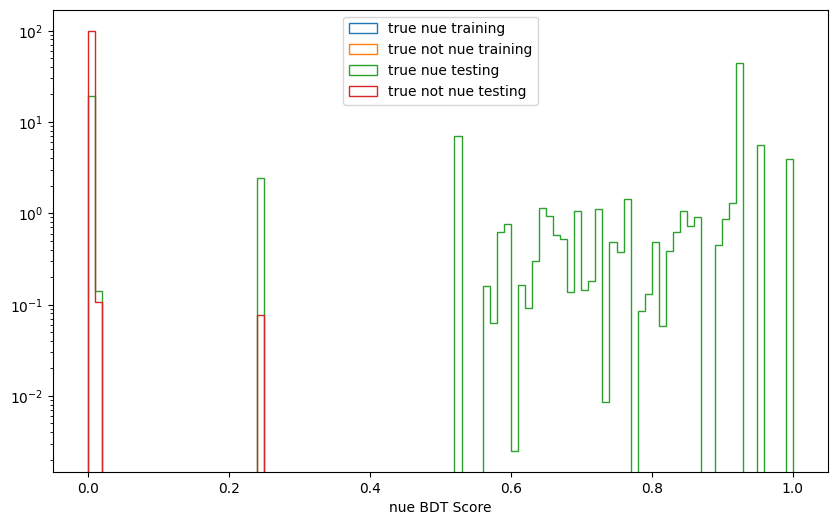

In [6]:
full_pred_true_nueCC = presel_merged_df.query("filetype != 'data' and filetype != 'delete_one_gamma_overlay' and filetype != 'isotropic_one_gamma_overlay' and wc_truth_isCC==1 and abs(wc_truth_nuPdg)==12")
full_pred_true_notnueCC = presel_merged_df.query("filetype != 'data' and filetype != 'delete_one_gamma_overlay' and filetype != 'isotropic_one_gamma_overlay' and not (wc_truth_isCC==1 and abs(wc_truth_nuPdg)==12)")

full_pred_true_nueCC_train = full_pred_true_nueCC.query("used_for_training == True")
full_pred_true_notnueCC_train = full_pred_true_notnueCC.query("used_for_training == True")
full_pred_true_nueCC_test = full_pred_true_nueCC.query("used_for_testing == True")
full_pred_true_notnueCC_test = full_pred_true_notnueCC.query("used_for_testing == True")

print(f"{full_pred_true_nueCC_train.shape=}")
print(f"{full_pred_true_notnueCC_train.shape=}")
print(f"{full_pred_true_nueCC_test.shape=}")
print(f"{full_pred_true_notnueCC_test.shape=}")

bins = np.linspace(0, 1, 101)

plt.figure(figsize=(10, 6))
#plt.hist(full_pred_true_nueCC["prob_nueCC_Np"], weights=full_pred_true_nueCC["wc_net_weight"], bins=bins, label="true nueCC", density=True, histtype="step")
#plt.hist(full_pred_true_notnueCC["prob_nueCC_Np"], weights=full_pred_true_notnueCC["wc_net_weight"], bins=bins, label="true not nueCC", density=True, histtype="step")
plt.hist(full_pred_true_nueCC_train["prob_nue"], weights=full_pred_true_nueCC_train["wc_net_weight"], bins=bins, label="true nue training", density=True, histtype="step")
plt.hist(full_pred_true_notnueCC_train["prob_nue"], weights=full_pred_true_notnueCC_train["wc_net_weight"], bins=bins, label="true not nue training", density=True, histtype="step")
plt.hist(full_pred_true_nueCC_test["prob_nue"], weights=full_pred_true_nueCC_test["wc_net_weight"], bins=bins, label="true nue testing", density=True, histtype="step")
plt.hist(full_pred_true_notnueCC_test["prob_nue"], weights=full_pred_true_notnueCC_test["wc_net_weight"], bins=bins, label="true not nue testing", density=True, histtype="step")
plt.yscale("log")
plt.legend()
plt.xlabel("nue BDT Score")
plt.show()

343738
177823
10755


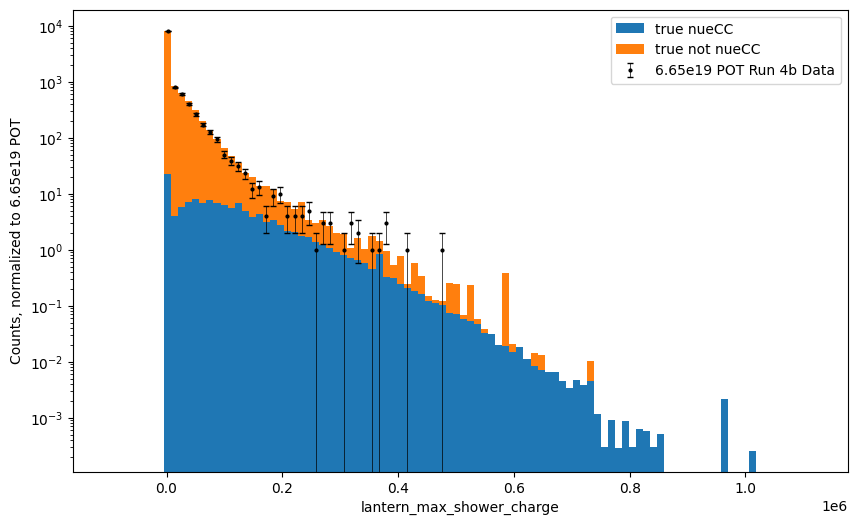

343738
177823
10755


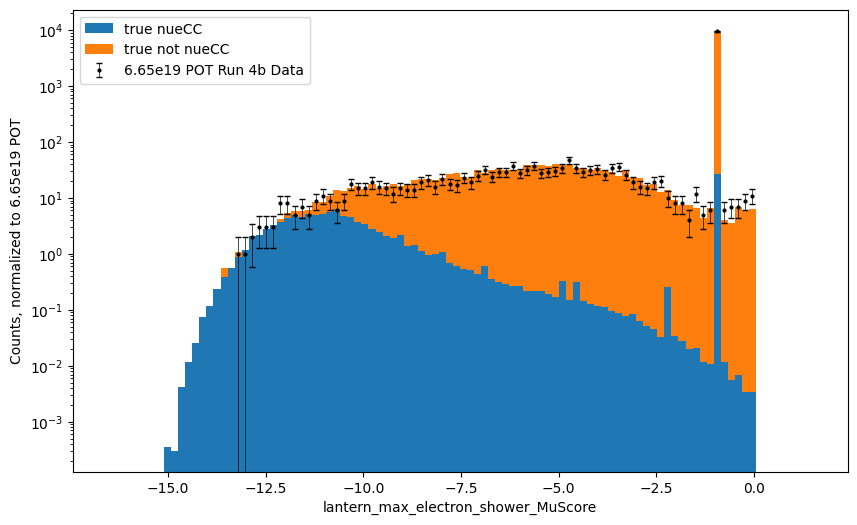

343738
177823
10755


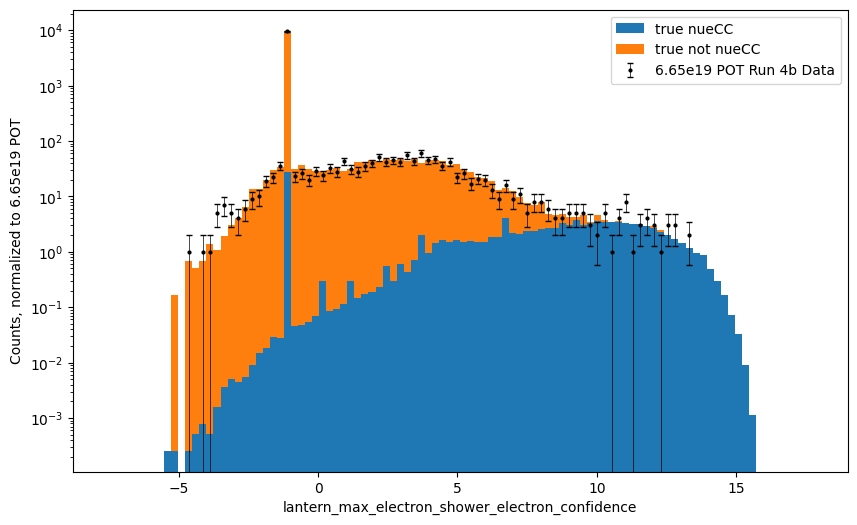

343738
177823
10755


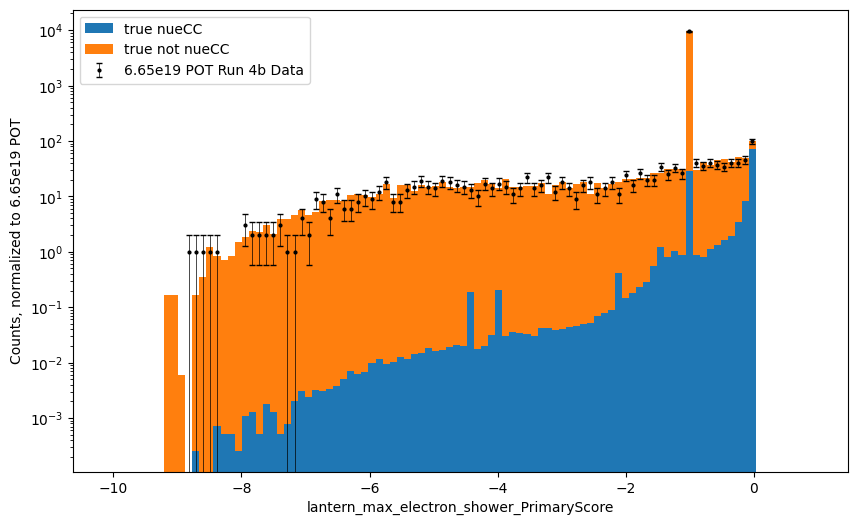

In [7]:
#for var in lantern_training_vars:
for var in ["lantern_max_shower_charge", "lantern_max_electron_shower_MuScore", "lantern_max_electron_shower_electron_confidence", "lantern_max_electron_shower_PrimaryScore"]:

    true_nueCC_vals = full_pred_true_nueCC[var].to_numpy()
    true_nueCC_weights = full_pred_true_nueCC["wc_net_weight"].to_numpy()
    true_notnueCC_vals = full_pred_true_notnueCC[var].to_numpy()
    true_notnueCC_weights = full_pred_true_notnueCC["wc_net_weight"].to_numpy()

    data_vals = presel_merged_df.query("filetype == 'data'")[var].to_numpy()
    data_weights = presel_merged_df.query("filetype == 'data'")["wc_net_weight"].to_numpy()

    true_nueCC_vals = np.nan_to_num(true_nueCC_vals, nan=-1)
    true_notnueCC_vals = np.nan_to_num(true_notnueCC_vals, nan=-1)
    data_vals = np.nan_to_num(data_vals, nan=-1)

    print(len(true_nueCC_vals))
    print(len(true_notnueCC_vals))
    print(len(data_vals))

    xmin = np.min([np.min(true_nueCC_vals), np.min(true_notnueCC_vals), np.min(data_vals)])
    xmax = np.max([np.max(true_nueCC_vals), np.max(true_notnueCC_vals), np.max(data_vals)])
    diff = xmax - xmin
    if diff == 0:
        diff = 0.01

    bins = np.linspace(xmin - diff/10, xmax + diff/10, 101)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    data_counts = np.histogram(data_vals, weights=data_weights, bins=bins)[0]

    plt.figure(figsize=(10, 6))
    plt.hist([true_nueCC_vals, true_notnueCC_vals], weights=[true_nueCC_weights, true_notnueCC_weights], bins=bins, label=["true nueCC", "true not nueCC"], stacked=True)
    plt.errorbar(bin_centers, data_counts, yerr=np.sqrt(data_counts), fmt="o", color="k", lw=0.5, capsize=2, capthick=1, markersize=2, label="6.65e19 POT Run 4b Data")
    plt.yscale("log")
    plt.legend()
    plt.xlabel(var)
    plt.ylabel("Counts, normalized to 6.65e19 POT")
    plt.show()


In [8]:
wc_inclusive_selected_flag = []
shw_sp_n_20mev_showers_vals = presel_merged_df["wc_shw_sp_n_20mev_showers"].to_numpy()
reco_nuvtxX_vals = presel_merged_df["wc_reco_nuvtxX"].to_numpy()
reco_nuvtxY_vals = presel_merged_df["wc_reco_nuvtxY"].to_numpy()
reco_nuvtxZ_vals = presel_merged_df["wc_reco_nuvtxZ"].to_numpy()
single_photon_numu_score_vals = presel_merged_df["wc_single_photon_numu_score"].to_numpy()
single_photon_other_score_vals = presel_merged_df["wc_single_photon_other_score"].to_numpy()
single_photon_ncpi0_score_vals = presel_merged_df["wc_single_photon_ncpi0_score"].to_numpy()
single_photon_nue_score_vals = presel_merged_df["wc_single_photon_nue_score"].to_numpy()
shw_sp_n_20br1_showers_vals = presel_merged_df["wc_shw_sp_n_20br1_showers"].to_numpy()
for i in tqdm(range(len(presel_merged_df))):
    if (shw_sp_n_20mev_showers_vals[i] > 0
         and reco_nuvtxX_vals[i] > 5.0 and reco_nuvtxX_vals[i] < 250.0
           and single_photon_numu_score_vals[i] > 0.4 and single_photon_other_score_vals[i] > 0.2
             and single_photon_ncpi0_score_vals[i] > -0.05 and single_photon_nue_score_vals[i] > -1.0
               and shw_sp_n_20br1_showers_vals[i] == 1):
        wc_inclusive_selected_flag.append(1)
    else:
        wc_inclusive_selected_flag.append(0)
presel_merged_df["erin_inclusive_1g_sel"] = wc_inclusive_selected_flag


  0%|          | 0/639131 [00:00<?, ?it/s]

/tmp/ipykernel_14297/2650567077.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  presel_merged_df["erin_inclusive_1g_sel"] = wc_inclusive_selected_flag


In [9]:
probs_2d_arr = presel_merged_df[prob_categories].to_numpy()
reco_categories_argmax = np.argmax(probs_2d_arr, axis=1)
presel_merged_df["reco_category_argmax_index"] = reco_categories_argmax

reco_category_queries = []
for i, signal_category in enumerate(sig_categories):
    reco_category_queries.append(f"reco_category_argmax_index == {i}")


/tmp/ipykernel_14297/980883663.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  presel_merged_df["reco_category_argmax_index"] = reco_categories_argmax


# Preselection Histogram

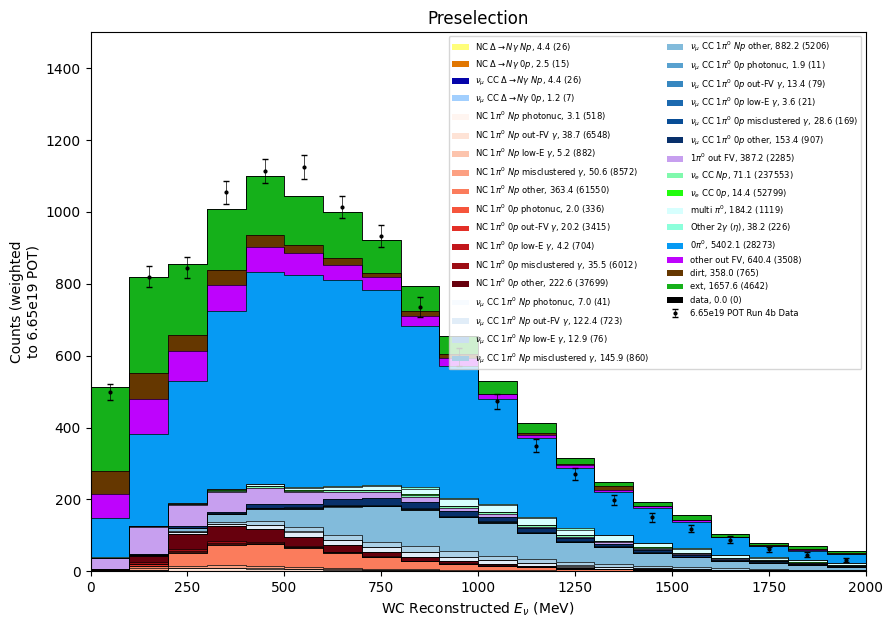

In [10]:
mpl.rcParams['hatch.linewidth'] = 0.2

del1g_norm_factor = 0.5
iso1g_norm_factor = 0.05
skip_del1g_iso1g = True

breakdown_labels = del1g_detailed_category_labels
breakdown_labels_latex = del1g_detailed_category_labels_latex
breakdown_colors = del1g_detailed_category_colors
breakdown_hatches = del1g_detailed_category_hatches
breakdown_queries = []
for label in breakdown_labels:
    breakdown_queries.append(f"del1g_detailed_signal_category == '{label}'")

plt.figure(figsize=(10, 7))

bins = np.linspace(0, 2000, 21)
bin_centers = (bins[:-1] + bins[1:]) / 2

sel_df = presel_merged_df

pred_sel_df = sel_df.query("filetype != 'data'")
data_sel_df = sel_df.query("filetype == 'data'")

breakdown_counts = []
unweighted_breakdown_counts = []
for breakdown_i, breakdown_label in enumerate(breakdown_labels):
    curr_df = pred_sel_df.query(breakdown_queries[breakdown_i])
    breakdown_counts.append(np.histogram(curr_df["wc_kine_reco_Enu"], weights=curr_df["wc_net_weight"], bins=bins)[0])
    unweighted_breakdown_counts.append(np.histogram(curr_df["wc_kine_reco_Enu"], bins=bins)[0])
data_counts = np.histogram(data_sel_df["wc_kine_reco_Enu"], bins=bins)[0]

bottom = np.zeros(len(bins)-1)
for breakdown_i, (breakdown_label, breakdown_count, unweighted_breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, breakdown_counts, unweighted_breakdown_counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
    if "iso1g" in breakdown_label:
        breakdown_count = breakdown_count * iso1g_norm_factor
        if skip_del1g_iso1g:
            continue
    elif "del1g" in breakdown_label:
        breakdown_count = breakdown_count * del1g_norm_factor
        if skip_del1g_iso1g:
            continue

    curr_breakdown_label = f"{breakdown_label_latex}, {np.sum(breakdown_count):.1f} ({np.sum(unweighted_breakdown_count):.0f})"
    n, _, _ = plt.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=curr_breakdown_label)

    plt.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)

    if breakdown_i == 0:
        bottom = n
    else:
        bottom += n

plt.errorbar(bin_centers, data_counts, yerr=np.sqrt(data_counts), fmt="o", color="k", lw=0.5, capsize=2, capthick=1, markersize=2, label="6.65e19 POT Run 4b Data")

plt.xlabel(r"WC Reconstructed $E_\nu$ (MeV)")
plt.ylabel("Counts (weighted\nto 6.65e19 POT)")
plt.title(f"Preselection")
plt.xlim(0, 2000)
plt.ylim(0, 1500)
plt.legend(ncol=2, loc='upper right', fontsize=6)
plt.show()


## Some LANTERN Variables

NameError: name 'total_pred_counts' is not defined

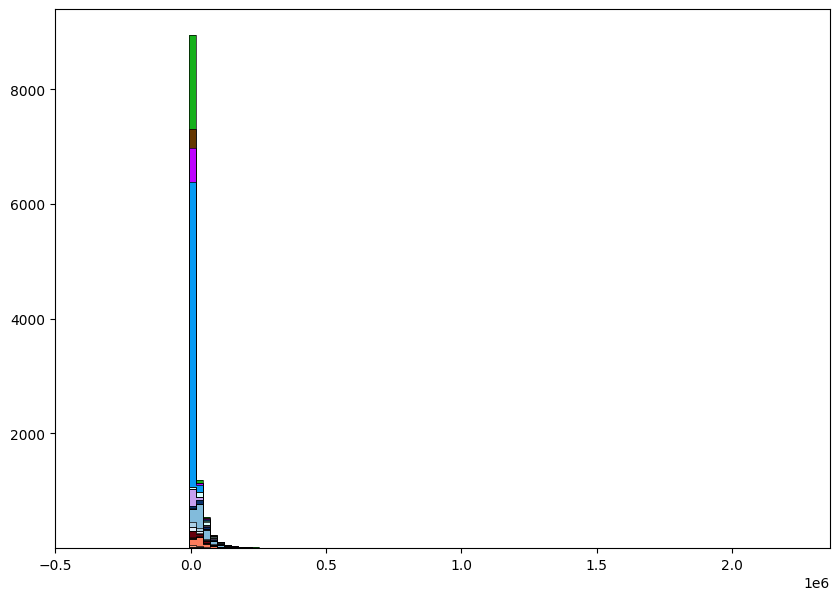

In [11]:
del1g_norm_factor = 0.5
iso1g_norm_factor = 0.05
skip_del1g_iso1g = True

for var in ["lantern_max_shower_charge", "lantern_max_electron_shower_MuScore", "lantern_max_electron_shower_electron_confidence", "lantern_max_electron_shower_PrimaryScore"][:1]:
#for var in lantern_training_vars:

    sel_df = presel_merged_df

    all_x_vals = sel_df[var].to_numpy()
    not_nan_finite_vals = all_x_vals[np.isfinite(all_x_vals)]
    if len(not_nan_finite_vals) == 0:
        min_x = 0
        max_x = 0
    else:
        min_x = np.min(not_nan_finite_vals)
        max_x = np.max(not_nan_finite_vals)

    diff = max_x - min_x
    if diff == 0:
        diff = 0.01
    nan_val = min_x - diff / 20
    neginf_val = min_x - diff / 10
    posinf_val = max_x + diff / 10

    bins = np.linspace(min_x - diff/5, max_x + diff/5, 101)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    pred_sel_df = sel_df.query("filetype != 'data'")
    data_sel_df = sel_df.query("filetype == 'data'")

    breakdown_counts = []
    unweighted_breakdown_counts = []
    for breakdown_i, breakdown_label in enumerate(breakdown_labels):
        curr_df = pred_sel_df.query(breakdown_queries[breakdown_i])
        breakdown_counts.append(np.histogram(np.nan_to_num(curr_df[var], nan=nan_val, posinf=posinf_val, neginf=neginf_val), weights=curr_df["wc_net_weight"], bins=bins)[0])
        unweighted_breakdown_counts.append(np.histogram(np.nan_to_num(curr_df[var], nan=nan_val, posinf=posinf_val, neginf=neginf_val), bins=bins)[0])
    data_counts = np.histogram(np.nan_to_num(data_sel_df[var], nan=nan_val, posinf=posinf_val, neginf=neginf_val), bins=bins)[0]

    plt.figure(figsize=(10, 7))

    bottom = np.zeros(len(bins)-1)
    for breakdown_i, (breakdown_label, breakdown_count, unweighted_breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, breakdown_counts, unweighted_breakdown_counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
        if "iso1g" in breakdown_label:
            breakdown_count = breakdown_count * iso1g_norm_factor
            if skip_del1g_iso1g:
                continue
        elif "del1g" in breakdown_label:
            breakdown_count = breakdown_count * del1g_norm_factor
            if skip_del1g_iso1g:
                continue
        elif "data" in breakdown_label:
            continue

        curr_breakdown_label = f"{breakdown_label_latex}, {np.sum(breakdown_count):.1f} ({np.sum(unweighted_breakdown_count):.0f})"
        n, _, _ = plt.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=curr_breakdown_label)

        plt.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)

        if breakdown_i == 0:
            bottom = n
        else:
            bottom += n

    plt.hist(bin_centers, weights=total_pred_counts, bins=bins, bottom=bottom, histtype="step", color="k", lw=0.5, label="Total Preds")

    plt.errorbar(bin_centers, data_counts, yerr=np.sqrt(data_counts), fmt="o", color="k", lw=0.5, capsize=2, capthick=1, markersize=2, label="6.65e19 POT Run 4b Data")

    plt.xlabel(var)
    plt.ylabel("Counts (weighted\nto 6.65e19 POT)")
    plt.title(f"Preselection")
    plt.xlim(bins[0], bins[-1])
    plt.yscale("log")
    plt.ylim(1e-2, 1e7)
    plt.legend(ncol=2, loc='upper right', fontsize=6)
    plt.show()



In [ ]:
print(1/0)

ZeroDivisionError: division by zero

# BDT Score Plots

In [ ]:
del1g_norm_factor = 0.5
iso1g_norm_factor = 0.05
skip_del1g_iso1g = True

for category in ["1gNp", "1g0p", "1gNp1mu", "1g0p1mu", "nueCC_Np", "nueCC_0p"]:
#for category in ["nueCC_Np", "nueCC_0p"]:

    plt.figure(figsize=(10, 7))

    bins = np.linspace(0, 1, 21)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    sel_df = presel_merged_df

    pred_sel_df = sel_df.query("filetype != 'data'")
    data_sel_df = sel_df.query("filetype == 'data'")

    breakdown_counts = []
    unweighted_breakdown_counts = []
    for breakdown_i, breakdown_label in enumerate(breakdown_labels):
        curr_df = pred_sel_df.query(breakdown_queries[breakdown_i])
        breakdown_counts.append(np.histogram(curr_df["prob_" + category], weights=curr_df["wc_net_weight"], bins=bins)[0])
        unweighted_breakdown_counts.append(np.histogram(curr_df["prob_" + category], bins=bins)[0])
    data_counts = np.histogram(data_sel_df["prob_" + category], bins=bins)[0]

    bottom = np.zeros(len(bins)-1)
    for breakdown_i, (breakdown_label, breakdown_count, unweighted_breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, breakdown_counts, unweighted_breakdown_counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
        if "iso1g" in breakdown_label:
            breakdown_count = breakdown_count * iso1g_norm_factor
            if skip_del1g_iso1g:
                continue
        elif "del1g" in breakdown_label:
            breakdown_count = breakdown_count * del1g_norm_factor
            if skip_del1g_iso1g:
                continue
        elif "data" in breakdown_label:
            continue

        curr_breakdown_label = f"{breakdown_label_latex}, {np.sum(breakdown_count):.1f} ({np.sum(unweighted_breakdown_count):.0f})"
        n, _, _ = plt.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=curr_breakdown_label)

        plt.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)

        if breakdown_i == 0:
            bottom = n
        else:
            bottom += n

    plt.errorbar(bin_centers, data_counts, yerr=np.sqrt(data_counts), fmt="o", color="k", lw=0.5, capsize=2, capthick=1, markersize=2, label="6.65e19 POT Run 4b Data")

    plt.xlabel(fr"{category} BDT Score")
    plt.ylabel("Counts (weighted\nto 6.65e19 POT)")
    plt.title(f"Preselection")
    plt.xlim(0, 1)
    plt.yscale("log")
    plt.ylim(1e-2, 1e7)
    plt.legend(ncol=2, loc='upper right', fontsize=6)
    plt.show()



# Multi-Class Histograms

In [ ]:
mpl.rcParams['hatch.linewidth'] = 0.2

del1g_norm_factor = 0.5
iso1g_norm_factor = 0.05
skip_del1g_iso1g = True

fig, axs = plt.subplots(7, 5, figsize=(20, 20))
axs = axs.flatten()

bins = np.linspace(0, 2000, 21)
bin_centers = (bins[:-1] + bins[1:]) / 2

for i in tqdm(range(len(sig_categories))):

    signal_category = sig_categories[i]
    signal_category_latex = sig_category_labels_latex[i]

    sel_df = presel_merged_df.query(reco_category_queries[i])

    pred_sel_df = sel_df.query("filetype != 'data'")
    data_sel_df = sel_df.query("filetype == 'data'")

    breakdown_counts = []
    for breakdown_i, breakdown_label in enumerate(breakdown_labels):
        curr_df = pred_sel_df.query(breakdown_queries[breakdown_i])
        breakdown_counts.append(np.histogram(curr_df["wc_kine_reco_Enu"], weights=curr_df["wc_net_weight"], bins=bins)[0])
    data_counts = np.histogram(data_sel_df["wc_kine_reco_Enu"], bins=bins)[0]

    axnum = i
    if i >= 12: # background categories, start new row
        axnum = i + 3

    bottom = np.zeros(len(bins)-1)
    for breakdown_i, (breakdown_label, breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, breakdown_counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
        if "iso1g" in breakdown_label:
            breakdown_count = breakdown_count * iso1g_norm_factor
            if skip_del1g_iso1g:
                continue
        elif "del1g" in breakdown_label:
            breakdown_count = breakdown_count * del1g_norm_factor
            if skip_del1g_iso1g:
                continue
        elif "data" in breakdown_label:
            continue

        n, _, _ = axs[axnum].hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=breakdown_label_latex)
        axs[axnum].hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)

        if breakdown_i == 0:
            bottom = n
        else:
            bottom += n

    axs[axnum].errorbar(bin_centers, data_counts, yerr=np.sqrt(data_counts), fmt="o", color="k", lw=0.5, capsize=2, capthick=1, markersize=2, label="6.65e19 POT Run 4b Data")

    max_pred = np.max(bottom)
    max_data = np.max(data_counts)

    axs[axnum].set_ylim(0, max(max_pred, max_data) * 1.1)

    if axnum == 19:
        axs[axnum].legend(ncol=4, loc='upper right', bbox_to_anchor=(-1, -0.5))

    if axnum in [15, 16, 17, 18, 19]:
        axs[axnum].set_xlabel(r"WC Reconstructed $E_\nu$ (MeV)")
    if axnum % 5 == 0: # Only show y-label for leftmost column
        axs[axnum].set_ylabel("Counts (weighted\nto 6.65e19 POT)")
    axs[axnum].set_title(f"{signal_category_latex} Selection")
    axs[axnum].set_xlim(0, 2000)

for axnum in range(len(axs)):
    if axnum in [12, 13, 14] or axnum > 19:
        axs[axnum].remove()

fig.subplots_adjust(hspace=0.5, wspace=0.3, bottom=0.15)

plt.savefig(f"../plots/multiclass_histograms_{training}.pdf")
plt.savefig(f"../plots/multiclass_histograms_{training}.png")
plt.show()


In [ ]:
print_all_plots_with_1g_sig = False
if print_all_plots_with_1g_sig:
    
    for i in range(len(sig_categories)):
        signal_category = sig_categories[i]
        signal_category_latex = sig_category_labels_latex[i]

        sel_df = presel_merged_df.query(reco_category_queries[i])

        bins = np.linspace(0, 2000, 21)
        bin_centers = (bins[:-1] + bins[1:]) / 2

        counts = []
        unweighted_counts = []
        for breakdown_i, breakdown_label in enumerate(breakdown_labels):
            curr_df = sel_df.query(breakdown_queries[breakdown_i])
            counts.append(np.histogram(curr_df["wc_kine_reco_Enu"], weights=curr_df["wc_net_weight"], bins=bins)[0])
            unweighted_counts.append(np.histogram(curr_df["wc_kine_reco_Enu"], bins=bins)[0])

        fig, ax = plt.subplots(figsize=(10, 5))

        bottom = np.zeros(len(bins)-1)
        for breakdown_i, (breakdown_label, breakdown_count, unweighted_breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, counts, unweighted_counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
            if "iso1g" in breakdown_label:
                breakdown_count = breakdown_count * iso1g_norm_factor
            elif "del1g" in breakdown_label:
                breakdown_count = breakdown_count * del1g_norm_factor
            elif "data" in breakdown_label:
                continue

            curr_breakdown_label = f"{breakdown_label_latex}, {np.sum(breakdown_count):.1f} ({np.sum(unweighted_breakdown_count):.0f})"


            n, _, _ = ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=curr_breakdown_label)
            ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)

            if breakdown_i == 0:
                bottom = n
            else:
                bottom += n

        ax.set_ylim(0, np.max(bottom) * 1.1)
        ax.set_xlabel(r"WC Reconstructed $E_\nu$ (MeV)")
        ax.set_ylabel("Counts (weighted to 6.65e19 POT)")
        ax.set_title(f"{signal_category_latex} Selection")
        ax.set_xlim(0, 2000)
        ax.legend(ncol=2, loc='upper right', fontsize=6)

        plt.savefig(f"../plots/multiclass_histograms_{training}_{signal_category}.pdf")
        plt.savefig(f"../plots/multiclass_histograms_{training}_{signal_category}.png")
        plt.show()

In [ ]:
print_all_plots_without_1g_sig = False
if print_all_plots_without_1g_sig:

    for i in range(len(sig_categories)):
        signal_category = sig_categories[i]
        signal_category_latex = sig_category_labels_latex[i]

        sel_df = presel_merged_df.query(reco_category_queries[i])

        bins = np.linspace(0, 2000, 21)
        bin_centers = (bins[:-1] + bins[1:]) / 2

        counts = []
        unweighted_counts = []
        for breakdown_i, breakdown_label in enumerate(breakdown_labels):
            curr_df = sel_df.query(breakdown_queries[breakdown_i])
            counts.append(np.histogram(curr_df["wc_kine_reco_Enu"], weights=curr_df["wc_net_weight"], bins=bins)[0])
            unweighted_counts.append(np.histogram(curr_df["wc_kine_reco_Enu"], bins=bins)[0])

        fig, ax = plt.subplots(figsize=(10, 5))

        bottom = np.zeros(len(bins)-1)
        for breakdown_i, (breakdown_label, breakdown_count, unweighted_breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, counts, unweighted_counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
            if "iso1g" in breakdown_label:
                continue
            elif "del1g" in breakdown_label:
                continue
            elif "data" in breakdown_label:
                continue

            curr_breakdown_label = f"{breakdown_label_latex}, {np.sum(breakdown_count):.1f} ({np.sum(unweighted_breakdown_count):.0f})"


            n, _, _ = ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=curr_breakdown_label)
            ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)

            if breakdown_i == 0:
                bottom = n
            else:
                bottom += n

        ax.set_ylim(0, np.max(bottom) * 1.1)
        ax.set_xlabel(r"WC Reconstructed $E_\nu$ (MeV)")
        ax.set_ylabel("Counts (weighted to 6.65e19 POT)")
        ax.set_title(f"{signal_category_latex} Selection")
        ax.set_xlim(0, 2000)
        ax.legend(ncol=2, loc='upper right', fontsize=6)

        plt.savefig(f"../plots/multiclass_histograms_{training}_{signal_category}_nosig.pdf")
        plt.savefig(f"../plots/multiclass_histograms_{training}_{signal_category}_nosig.png")
        plt.show()

# One Shower Plots

## Multi-class BDT

In [ ]:
refined_1g_queries = [
    "prob_1gNp > 0.5",
    "prob_1g0p > 0.95",
    "prob_1gNp1mu > 0.8",
    "prob_1g0p1mu > 0.3",
    "prob_nueCC_Np > 0.15",
    "prob_nueCC_0p > 0.1",
]

for plot_i in range(6):
    reco_category_i = [0, 1, 2, 3, 10, 11][plot_i]
    signal_category = sig_categories[reco_category_i]
    signal_category_latex = sig_category_labels_latex[reco_category_i]

    sel_df = presel_merged_df.query(refined_1g_queries[plot_i])

    pred_sel_df = sel_df.query("filetype != 'data'")
    data_sel_df = sel_df.query("filetype == 'data'")

    bins = np.linspace(0, 3000, 21)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    breakdown_counts = []
    unweighted_breakdown_counts = []
    for breakdown_i, breakdown_label in enumerate(breakdown_labels):
        curr_df = pred_sel_df.query(breakdown_queries[breakdown_i])
        breakdown_counts.append(np.histogram(curr_df["wc_kine_reco_Enu"], weights=curr_df["wc_net_weight"], bins=bins)[0])
        unweighted_breakdown_counts.append(np.histogram(curr_df["wc_kine_reco_Enu"], bins=bins)[0])

    data_counts = np.histogram(data_sel_df["wc_kine_reco_Enu"], bins=bins)[0]

    fig, ax = plt.subplots(figsize=(10, 5))

    bottom = np.zeros(len(bins)-1)
    for breakdown_i, (breakdown_label, breakdown_count, unweighted_breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, breakdown_counts, unweighted_breakdown_counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
        if "iso1g" in breakdown_label:
            continue
        elif "del1g" in breakdown_label:
            continue
        elif "data" in breakdown_label:
            continue

        curr_breakdown_label = f"{breakdown_label_latex}, {np.sum(breakdown_count):.1f} ({np.sum(unweighted_breakdown_count):.0f})"

        n, _, _ = ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=curr_breakdown_label)
        ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)

        if breakdown_i == 0:
            bottom = n
        else:
            bottom += n

    ax.errorbar(bin_centers, data_counts, yerr=np.sqrt(data_counts), fmt="o", color="k", lw=0.5, capsize=2, capthick=1, markersize=2, label=f"6.65e19 POT Run 4b Data ({np.sum(data_counts)})")

    max_pred = np.max(bottom)
    max_data = np.max(data_counts)

    ax.set_ylim(0, max(max_pred, max_data) * 1.1)
    ax.set_xlabel(r"WC Reconstructed $E_\nu$ (MeV)")
    ax.set_ylabel("Counts (weighted to 6.65e19 POT)")
    ax.set_title(f"{signal_category_latex} Selection")
    ax.set_xlim(0, 3000)
    ax.legend(ncol=2, loc='upper right', fontsize=6)

    plt.savefig(f"../plots/refined_multiclass_histograms_{training}_{signal_category}_nosig.pdf")
    plt.savefig(f"../plots/refined_multiclass_histograms_{training}_{signal_category}_nosig.png")
    plt.show()

## Older 1g selections

In [ ]:
for plot in ["presel", "NCDeltaRad_1gNp", "NCDeltaRad_1g0p", "erin_inclusive_1g", "WC_nueCC_Np", "WC_nueCC_0p"]:
    
    if plot == "presel":
        sel_df = presel_merged_df
    elif plot == "NCDeltaRad_1gNp":
        sel_df = presel_merged_df.query("wc_kine_reco_Enu > 0 and wc_nc_delta_score > 2.61 and wc_reco_num_protons>0")
    elif plot == "NCDeltaRad_1g0p":
        sel_df = presel_merged_df.query("wc_kine_reco_Enu > 0 and wc_nc_delta_score > 2.61 and wc_reco_num_protons==0")
    elif plot == "erin_inclusive_1g":
        sel_df = presel_merged_df.query("erin_inclusive_1g_sel == 1")
    elif plot == "WC_nueCC_Np":
        sel_df = presel_merged_df.query("wc_nue_score > 7 and wc_reco_num_protons>0")
    elif plot == "WC_nueCC_0p":
        sel_df = presel_merged_df.query("wc_nue_score > 7 and wc_reco_num_protons==0")

    pred_sel_df = sel_df.query("filetype != 'data'")
    data_sel_df = sel_df.query("filetype == 'data'")

    bins = np.linspace(0, 3000, 21)
    bin_centers = (bins[:-1] + bins[1:]) / 2

    breakdown_counts = []
    unweighted_breakdown_counts = []
    for breakdown_i, breakdown_label in enumerate(breakdown_labels):
        curr_df = pred_sel_df.query(breakdown_queries[breakdown_i])
        breakdown_counts.append(np.histogram(curr_df["wc_kine_reco_Enu"], weights=curr_df["wc_net_weight"], bins=bins)[0])
        unweighted_breakdown_counts.append(np.histogram(curr_df["wc_kine_reco_Enu"], bins=bins)[0])

    data_counts = np.histogram(data_sel_df["wc_kine_reco_Enu"], bins=bins)[0]

    fig, ax = plt.subplots(figsize=(10, 5))

    bottom = np.zeros(len(bins)-1)
    for breakdown_i, (breakdown_label, breakdown_count, unweighted_breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, breakdown_counts, unweighted_breakdown_counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
        if "iso1g" in breakdown_label:
            continue
        elif "del1g" in breakdown_label:
            continue
        elif "data" in breakdown_label:
            continue

        curr_breakdown_label = f"{breakdown_label_latex}, {np.sum(breakdown_count):.1f} ({np.sum(unweighted_breakdown_count):.0f})"

        n, _, _ = ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=curr_breakdown_label)
        ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)

        if breakdown_i == 0:
            bottom = n
        else:
            bottom += n

    max_pred = np.max(bottom)
    max_data = np.max(data_counts)

    ax.errorbar(bin_centers, data_counts, yerr=np.sqrt(data_counts), fmt="o", color="k", lw=0.5, capsize=2, capthick=1, markersize=2, label=f"6.65e19 POT Run 4b Data ({np.sum(data_counts)})")

    ax.set_ylim(0, max(max_pred, max_data) * 1.1)
    ax.set_xlabel(r"WC Reconstructed $E_\nu$ (MeV)")
    ax.set_ylabel("Counts (weighted to 6.65e19 POT)")
    ax.set_title(f"{plot} Selection")
    ax.set_xlim(0, 3000)
    ax.legend(ncol=2, loc='upper right', fontsize=6)

    plt.savefig(f"../plots/refined_multiclass_histograms_{training}_{plot}_nosig.pdf")
    plt.savefig(f"../plots/refined_multiclass_histograms_{training}_{plot}_nosig.png")
    plt.show()


# Checking Event Weights

In [ ]:
del1g_norm_factor = 0.5
iso1g_norm_factor = 0.05

plt.figure(figsize=(10, 5))
ax = plt.gca()

bins = np.logspace(-2, 8, 51)
bin_centers = (bins[:-1] + bins[1:]) / 2
multi_bin_centers = [bin_centers] * len(breakdown_labels)
outline_colors = ["k"] * len(breakdown_labels)

sel_df = presel_merged_df
counts = []
for breakdown_i, breakdown_label in enumerate(breakdown_labels):
    curr_df = sel_df.query(breakdown_queries[breakdown_i])
    counts.append(np.histogram(curr_df["wc_net_weight"].to_numpy(), weights=curr_df["wc_net_weight"].to_numpy(), bins=bins)[0])

bottom = np.zeros(len(bins)-1)
for breakdown_i, (breakdown_label, breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
    if "iso1g" in breakdown_label:
        breakdown_count = breakdown_count * iso1g_norm_factor
    elif "del1g" in breakdown_label:
        breakdown_count = breakdown_count * del1g_norm_factor
    elif "data" in breakdown_label:
        continue
    n, _, _ = ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=breakdown_label_latex)
    ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)
    if breakdown_i == 0:
        bottom = n
    else:
        bottom += n

plt.xlabel(r"WC Net Weight")
plt.ylabel("Counts (weighted\nto 6.65e19 POT)")
plt.xlim(bins[0], bins[-1])
plt.xscale("log")
plt.yscale("log")
plt.legend(loc="upper right", ncol=2, fontsize=6)
plt.title("Preselection")
plt.show()



# Post-Selection Studies

In [ ]:
one_g_reco_category_argmax_indices = []
for i, signal_category in enumerate(sig_categories):
    if "1g" in signal_category:
        one_g_reco_category_argmax_indices.append(i)

combined_1g_query = ""
for i in one_g_reco_category_argmax_indices:
    combined_1g_query += f"reco_category_argmax_index == {i} or "
combined_1g_query = combined_1g_query[:-4]

all_1g_sel_df = presel_merged_df.query(combined_1g_query)

print(f"{presel_merged_df.shape=}")
print(f"{all_1g_sel_df.shape=}")

## Blip Veto

In [ ]:
del1g_norm_factor = 0
iso1g_norm_factor = 0.05
skip_del1g_iso1g = True

for sel_type in ["presel", "all_1g", "1g0p"]:
    if sel_type == "presel":
        sel_df = presel_merged_df
    elif sel_type == "all_1g":
        sel_df = all_1g_sel_df
    elif sel_type == "1g0p":
        sel_df = presel_merged_df.query("reco_category_argmax_index == 1")

    pred_sel_df = sel_df.query("filetype != 'data'")
    data_sel_df = sel_df.query("filetype == 'data'")
            
    blip_postprocessing_vars_bin_ranges = [
        ("blip_closest_upstream_distance", 0, 200),
        #("blip_closest_upstream_angle", 0, 90),
        #("blip_closest_upstream_impact_parameter", 0, 200),
        #("blip_closest_upstream_energy", 0, 20),
        #("blip_closest_upstream_dx", 0, 5),
        #("blip_closest_upstream_dw", 0, 5),
    ]

    for var, min_val, max_val in blip_postprocessing_vars_bin_ranges:

        plt.figure(figsize=(10, 5))
        ax = plt.gca()
        bins = np.linspace(min_val, max_val, 21)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        multi_bin_centers = [bin_centers] * len(breakdown_labels)
        outline_colors = ["k"] * len(breakdown_labels)

        breakdown_counts = []
        unweighted_breakdown_counts = []
        for breakdown_i, breakdown_label in enumerate(breakdown_labels):
            curr_df = pred_sel_df.query(breakdown_queries[breakdown_i])
            breakdown_counts.append(np.histogram(curr_df[var].to_numpy(), weights=curr_df["wc_net_weight"].to_numpy(), bins=bins)[0])
            unweighted_breakdown_counts.append(np.histogram(curr_df[var].to_numpy(), bins=bins)[0])

        data_counts = np.histogram(data_sel_df[var].to_numpy(), bins=bins)[0]
        
        bottom = np.zeros(len(bins)-1)
        for breakdown_i, (breakdown_label, breakdown_count, unweighted_breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, breakdown_counts, unweighted_breakdown_counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
            if "iso1g" in breakdown_label:
                breakdown_count = breakdown_count * iso1g_norm_factor
                if skip_del1g_iso1g:
                    continue
            elif "del1g" in breakdown_label:
                breakdown_count = breakdown_count * del1g_norm_factor
                if skip_del1g_iso1g:
                    continue
            elif "data" in breakdown_label:
                continue

            curr_breakdown_label = f"{breakdown_label_latex}, {np.sum(breakdown_count):.1f} ({np.sum(unweighted_breakdown_count):.0f})"

            n, _, _ = ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=curr_breakdown_label)
            ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)
            if breakdown_i == 0:
                bottom = n
            else:
                bottom += n

        plt.errorbar(bin_centers, data_counts, yerr=np.sqrt(data_counts), fmt="o", color="k", lw=0.5, capsize=2, capthick=1, markersize=2, label=f"6.65e19 POT Run 4b Data ({np.sum(data_counts)})")

        plt.xlabel(var)
        plt.ylabel("Counts (weighted\nto 6.65e19 POT)")
        plt.xlim(bins[0], bins[-1])
        plt.legend(loc="upper right", ncol=2, fontsize=6)
        if sel_type == "presel":
            plt.title(f"Preselection")
        elif sel_type == "1g0p":
            plt.title(f"1g0p Selection")
        elif sel_type == "all_1g":
            plt.title(f"All 1g Selection")

        plt.show()


## Nanosecond Timing

In [ ]:
del1g_norm_factor = 0.5
iso1g_norm_factor = 0.05

# related to https://github.com/brb-rightback/ns_demo_MCC9.10/blob/main/ns_demo_MCC9.10.ipynb
# TODO: Validate this with data and showers, see https://microboone-docdb.fnal.gov/cgi-bin/sso/ShowDocument?docid=44781
# Also check the manually applied shifts for all the different time periods

beamon_presel_merged_df = presel_merged_df.query("filetype == 'data'")
beamoff_presel_merged_df = presel_merged_df.query("filetype == 'ext'")
mc_presel_merged_df = presel_merged_df.query("not (filetype == 'data' or filetype == 'ext')")

beamoff_presel_merged_df["non_merge_time"] = beamoff_presel_merged_df["wc_evtTimeNS"]
beamon_presel_merged_df["non_merge_time"] = beamon_presel_merged_df["wc_evtTimeNS"] + 5700
mc_presel_merged_df["non_merge_time"] = mc_presel_merged_df["wc_evtTimeNS_cor"] + 1500 # manually shifting MC to approximately match data

data_presel_merged_df = pd.concat([beamoff_presel_merged_df, beamon_presel_merged_df, mc_presel_merged_df])

run = data_presel_merged_df["run"].to_numpy()
evtTimeNS = data_presel_merged_df["wc_evtTimeNS"].to_numpy()
new_times = []
for i in range(len(evtTimeNS)):
    gap=18.936
    Shift=0
    TThelp=0
    if (run[i] >= 19500): Shift=2920.5 
    elif (run[i] >= 17380): Shift=2916.0 
    elif (run[i] >= 13697): Shift = 3147.3
    elif (run[i] >= 10812): Shift = 3568.5 
    elif (run[i] >= 8321): Shift = 3610.7
    elif (run[i] >= 5800): Shift = 3164.4
    elif (run[i] > 0 ): Shift = 3168.9
    TThelp = evtTimeNS[i]-Shift+gap*0.5
    if np.isinf(TThelp):
        TThelp = np.nan
    TT_merged = -9999.
    if(TThelp>=0): 
        TT_merged=(TThelp-(int((TThelp)/gap))*gap)-gap*0.5
    new_times.append(TT_merged)
data_presel_merged_df["merge_time"] = new_times

evtTimeNS = mc_presel_merged_df["wc_evtTimeNS_cor"].to_numpy()
new_times = []
for i in range(len(evtTimeNS)):
    gap=18.936
    Shift=5.8-0.3
    TThelp=0
    TThelp = np.nan_to_num(evtTimeNS[i]-Shift+gap*0.5,nan=-9999)
    TT_merged = -9999.
    if(TThelp>=0):
        TT_merged=(TThelp-(int((TThelp)/gap))*gap)-gap*0.5
    new_times.append(TT_merged)
mc_presel_merged_df["merge_time"] = new_times

presel_merged_df = pd.concat([mc_presel_merged_df, data_presel_merged_df])
all_1g_sel_df = presel_merged_df.query(combined_1g_query)


In [ ]:
for sel_type in ["presel", "all_1g"]:
    if sel_type == "presel":
        sel_df = presel_merged_df
    elif sel_type == "all_1g":
        sel_df = all_1g_sel_df

    pred_sel_df = sel_df.query("filetype != 'data'")
    data_sel_df = sel_df.query("filetype == 'data'")

    plt.figure(figsize=(10, 5))
    ax = plt.gca()
    bins = np.linspace(8500, 11000, 21)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    multi_bin_centers = [bin_centers] * len(breakdown_labels)
    outline_colors = ["k"] * len(breakdown_labels)
    breakdown_counts = []
    unweighted_breakdown_counts = []
    for breakdown_i, breakdown_label in enumerate(breakdown_labels):
        curr_df = pred_sel_df.query(breakdown_queries[breakdown_i])
        breakdown_counts.append(np.histogram(curr_df["non_merge_time"].to_numpy(), weights=curr_df["wc_net_weight"].to_numpy(), bins=bins)[0])
        unweighted_breakdown_counts.append(np.histogram(curr_df["non_merge_time"].to_numpy(), bins=bins)[0])

    data_counts = np.histogram(data_sel_df["non_merge_time"].to_numpy(), bins=bins)[0]

    bottom = np.zeros(len(bins)-1)
    for breakdown_i, (breakdown_label, breakdown_count, unweighted_breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, breakdown_counts, unweighted_breakdown_counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
        if "iso1g" in breakdown_label:
            breakdown_count = breakdown_count * iso1g_norm_factor
            if skip_del1g_iso1g:
                continue
        elif "del1g" in breakdown_label:
            breakdown_count = breakdown_count * del1g_norm_factor
            if skip_del1g_iso1g:
                continue
        elif "data" in breakdown_label:
            continue
        curr_breakdown_label = f"{breakdown_label_latex}, {np.sum(breakdown_count):.1f} ({np.sum(unweighted_breakdown_count):.0f})"
        n, _, _ = ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=curr_breakdown_label)
        ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)
        if breakdown_i == 0:
            bottom = n
        else:
            bottom += n

    plt.errorbar(bin_centers, data_counts, yerr=np.sqrt(data_counts), fmt="o", color="k", lw=0.5, capsize=2, capthick=1, markersize=2, label=f"6.65e19 POT Run 4b Data ({np.sum(data_counts)})")

    max_pred = np.max(bottom)
    max_data = np.max(data_counts)

    plt.ylim(0, max(max_pred, max_data) * 1.1)

    plt.xlabel("non_merge_time")
    plt.ylabel("Counts (weighted\nto 6.65e19 POT)")
    plt.xlim(bins[0], bins[-1])
    plt.legend(loc="upper right", ncol=2, fontsize=6)
    if sel_type == "presel":
        plt.title(f"Preselection")
    else:
        plt.title(f"All 1g Sel")
    plt.show()


    plt.figure(figsize=(10, 5))
    ax = plt.gca()
    bins = np.linspace(-9.462531250000058, 9.462531250000058, 21)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    multi_bin_centers = [bin_centers] * len(breakdown_labels)
    outline_colors = ["k"] * len(breakdown_labels)
    breakdown_counts = []
    unweighted_breakdown_counts = []
    for breakdown_i, breakdown_label in enumerate(breakdown_labels):
        curr_df = pred_sel_df.query(breakdown_queries[breakdown_i])
        breakdown_counts.append(np.histogram(curr_df["merge_time"].to_numpy(), weights=curr_df["wc_net_weight"].to_numpy(), bins=bins)[0])
        unweighted_breakdown_counts.append(np.histogram(curr_df["merge_time"].to_numpy(), bins=bins)[0])

    data_counts = np.histogram(data_sel_df["merge_time"].to_numpy(), bins=bins)[0]

    bottom = np.zeros(len(bins)-1)
    for breakdown_i, (breakdown_label, breakdown_count, unweighted_breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, breakdown_counts, unweighted_breakdown_counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
        if "iso1g" in breakdown_label:
            breakdown_count = breakdown_count * iso1g_norm_factor
            if skip_del1g_iso1g:
                continue
        elif "del1g" in breakdown_label:
            breakdown_count = breakdown_count * del1g_norm_factor
            if skip_del1g_iso1g:
                continue
        elif "data" in breakdown_label:
            continue
        curr_breakdown_label = f"{breakdown_label_latex}, {np.sum(breakdown_count):.1f} ({np.sum(unweighted_breakdown_count):.0f})"
        n, _, _ = ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=curr_breakdown_label)
        ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)
        if breakdown_i == 0:
            bottom = n
        else:
            bottom += n

    plt.errorbar(bin_centers, data_counts, yerr=np.sqrt(data_counts), fmt="o", color="k", lw=0.5, capsize=2, capthick=1, markersize=2, label=f"6.65e19 POT Run 4b Data ({np.sum(data_counts)})")

    max_pred = np.max(bottom)
    max_data = np.max(data_counts)

    plt.ylim(0, max(max_pred, max_data) * 1.1)

    plt.xlabel("merge_time")
    plt.ylabel("Counts (weighted\nto 6.65e19 POT)")
    plt.xlim(bins[0], bins[-1])
    plt.legend(loc="upper right", ncol=2, fontsize=6)
    if sel_type == "presel":
        plt.title(f"Preselection")
    else:
        plt.title(f"All 1g Sel")
    plt.show()


## Out-TPC PMT Veto

In [ ]:
# TODO: Add more detailed PMT-by-PMT information, see https://github.com/kpulido444/REU_uboone_photon_rejection
# Could require SUPRPRISE files with newer WC PMT info

del1g_norm_factor = 0
iso1g_norm_factor = 0.05
skip_del1g_iso1g = True

print("WARNING: Missing detailed PMT Information for run 4b v10_04_07_09 files, for these missing file information we set chi2/ndf to -1!")
    
for sel_type in ["presel", "all_1g"]:
    if sel_type == "presel":
        sel_df = presel_merged_df
    elif sel_type == "all_1g":
        sel_df = all_1g_sel_df

    pred_sel_df = sel_df.query("filetype != 'data'")
    data_sel_df = sel_df.query("filetype == 'data'")

    plt.figure(figsize=(10, 5))
    ax = plt.gca()
    bins = np.linspace(-1, 5, 21)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    multi_bin_centers = [bin_centers] * len(breakdown_labels)
    outline_colors = ["k"] * len(breakdown_labels)
    breakdown_counts = []
    unweighted_breakdown_counts = []
    for breakdown_i, breakdown_label in enumerate(breakdown_labels):
        curr_df = pred_sel_df.query(breakdown_queries[breakdown_i])
        ratio = (curr_df["wc_flash_measPe"].to_numpy() - curr_df["wc_flash_predPe"].to_numpy()) / curr_df["wc_flash_predPe"].to_numpy()
        breakdown_counts.append(np.histogram(ratio, weights=curr_df["wc_net_weight"].to_numpy(), bins=bins)[0])
        unweighted_breakdown_counts.append(np.histogram(ratio, bins=bins)[0])

    data_counts = np.histogram((data_sel_df["wc_flash_measPe"].to_numpy() - data_sel_df["wc_flash_predPe"].to_numpy()) / data_sel_df["wc_flash_predPe"].to_numpy(), bins=bins)[0]

    bottom = np.zeros(len(bins)-1)
    for breakdown_i, (breakdown_label, breakdown_count, unweighted_breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, breakdown_counts, unweighted_breakdown_counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
        if "iso1g" in breakdown_label:
            breakdown_count = breakdown_count * iso1g_norm_factor
            if skip_del1g_iso1g:
                continue
        elif "del1g" in breakdown_label:
            breakdown_count = breakdown_count * del1g_norm_factor
            if skip_del1g_iso1g:
                continue
        elif "data" in breakdown_label:
            continue
        curr_breakdown_label = f"{breakdown_label_latex}, {np.sum(breakdown_count):.1f} ({np.sum(unweighted_breakdown_count):.0f})"
        n, _, _ = ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=curr_breakdown_label)
        ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)
        if breakdown_i == 0:
            bottom = n
        else:
            bottom += n
    plt.errorbar(bin_centers, data_counts, yerr=np.sqrt(data_counts), fmt="o", color="k", lw=0.5, capsize=2, capthick=1, markersize=2, label=f"6.65e19 POT Run 4b Data ({np.sum(data_counts)})")

    max_pred = np.max(bottom)
    max_data = np.max(data_counts)

    plt.ylim(0, max(max_pred, max_data) * 1.1)

    plt.xlabel("(meas - pred) / pred light")
    plt.ylabel("Counts (weighted\nto 6.65e19 POT)")
    plt.xlim(bins[0], bins[-1])
    plt.legend(loc="upper right", ncol=2, fontsize=6)
    if sel_type == "presel":
        plt.title(f"Preselection")
    else:
        plt.title(f"All 1g Sel")
    plt.show()

    plt.figure(figsize=(10, 5))
    ax = plt.gca()
    bins = np.linspace(-1, 10, 51)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    multi_bin_centers = [bin_centers] * len(breakdown_labels)
    outline_colors = ["k"] * len(breakdown_labels)
    breakdown_counts = []
    unweighted_breakdown_counts = []
    for breakdown_i, breakdown_label in enumerate(breakdown_labels):
        curr_df = pred_sel_df.query(breakdown_queries[breakdown_i])
        ratio = curr_df["wc_WCPMTInfoChi2"].to_numpy() / curr_df["wc_WCPMTInfoNDF"].to_numpy()
        ratio = np.nan_to_num(ratio, nan=-1, posinf=-1, neginf=-1)
        breakdown_counts.append(np.histogram(ratio, weights=curr_df["wc_net_weight"].to_numpy(), bins=bins)[0])
        unweighted_breakdown_counts.append(np.histogram(ratio, bins=bins)[0])

    data_counts = np.histogram(data_sel_df["wc_WCPMTInfoChi2"].to_numpy() / data_sel_df["wc_WCPMTInfoNDF"].to_numpy(), bins=bins)[0]

    bottom = np.zeros(len(bins)-1)
    for breakdown_i, (breakdown_label, breakdown_count, unweighted_breakdown_count, breakdown_color, breakdown_hatch, breakdown_label_latex) in enumerate(zip(breakdown_labels, breakdown_counts, unweighted_breakdown_counts, breakdown_colors, breakdown_hatches, breakdown_labels_latex)):
        if "iso1g" in breakdown_label:
            breakdown_count = breakdown_count * iso1g_norm_factor
            if skip_del1g_iso1g:
                continue
        elif "del1g" in breakdown_label:
            breakdown_count = breakdown_count * del1g_norm_factor
            if skip_del1g_iso1g:
                continue
        curr_breakdown_label = f"{breakdown_label_latex}, {np.sum(breakdown_count):.1f} ({np.sum(unweighted_breakdown_count):.0f})"
        n, _, _ = ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, color=breakdown_color, hatch=breakdown_hatch, label=curr_breakdown_label)
        ax.hist(bin_centers, weights=breakdown_count, bins=bins, bottom=bottom if breakdown_i > 0 else None, histtype="step", color="k", lw=0.5)
        if breakdown_i == 0:
            bottom = n
        else:
            bottom += n
    plt.errorbar(bin_centers, data_counts, yerr=np.sqrt(data_counts), fmt="o", color="k", lw=0.5, capsize=2, capthick=1, markersize=2, label=f"6.65e19 POT Run 4b Data ({np.sum(data_counts)})")

    max_pred = np.max(bottom)
    max_data = np.max(data_counts)
    plt.ylim(1e-2, max(max_pred, max_data) * 2)

    plt.xlabel(r"WC Flash Match $\chi^2 / NDF$")
    plt.ylabel("Counts (weighted\nto 6.65e19 POT)")
    plt.xlim(bins[0], bins[-1])
    plt.legend(loc="upper right", ncol=2, fontsize=6)
    if sel_type == "presel":
        plt.title(f"Preselection")
    else:
        plt.title(f"All 1g Sel")
    plt.yscale("log")
    plt.show()


## Out-TPC CRT Veto

In [ ]:
# TODO: Look at CRT information, and if we can identify in-time out-TPC activity associated with an event
# (even if there's no clean CRT track indicating a through-going cosmic muon)


# Out-TPC Geometric BDT

In [ ]:
# TODO: Look at just shower position and direction, use that to separate in-FV vs out-FV reco-1g events


## Spacepoint SSV

In [ ]:
# TODO: https://github.com/leehagaman/spacepoint_ssv
# Will require processing ntuples with all cosmic spacepoints turned on
